# **266 Final Project: SMS Spam Detection Model**

*Sunny Shin, Karsyn Lee, Raymond Tang*
```
objective
```
1. Accurately detect and differentiate between spam and ham SMS in a given input dataset.
2. Achieve a high level of precision and recall to minimize false positives and false negatives respectively.
3. Be scalable and adaptable to work with different texts and messages.

```
motivation
```
We are creating a Natural Language Processing (NLP) model that can effectively analyze and interpret the various components of an SMS, including the sender number and body, in order to accurately identify whether a text is spam or ham. By leveraging advanced machine learning techniques and training the model on a diverse dataset of both malicious and benign SMS, the team aims to create an intelligent system capable of detecting patterns, anomalies, and other indicators of spam vs non-spam.


## **Notebook Contents**
```
1. Setup
2. Import Data
3. Exploratory Data Analysis
4. Data Pre-processing
5. Baseline Model
6. RNN - LSTM
7. CNN
8. BERT
9. BERTweet
10. Performance
```

## **Step 1: Setup**

We first need to do the usual setup and import necessary packages.

In [ ]:
!pip install gensim --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet
!pip install imbalanced-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.6 MB/s eta 0:00:00


In [ ]:
# standard
import pandas as pd
import numpy as np
import random
import os
import cv2
import warnings
import shutil
import nltk
import string
from nltk.data import find
from google.colab import drive
drive.mount('/content/drive')

# tf and keras
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow import keras
from keras import models
from keras import layers
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Conv1D, MaxPooling1D, Flatten

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, zero_one_loss
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# bert
import torch
from transformers import AutoModel, AutoTokenizer, TFRobertaModel
# from TweetNormalizer import normalizeTweet
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

# import spacy for NLP and re for regular expressions
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

# word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from wordcloud import WordCloud

random.seed(2)
%matplotlib inline

#warning hadle
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

## **Step 2: Import Data**

We imported the [SMS Spam Collection data](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) from University of California, Irvine Machine Learning Repository. We then labeled the columns as 'Category' and 'Message'.

In [ ]:
%cd /content/drive/My Drive/266 Final Project/dataset/

df = pd.read_csv('SMSSpamCollection.csv', sep='\t',
                 names=['category','message'])
df.head()

/content/drive/.shortcut-targets-by-id/1MMMu36rH95iuaohlfqOQLFcKLpArlnhO/266 Final Project/dataset


,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## **Step 3: Exploratory Data Analysis**

We then explore our dataset further and summarize the composition of our dataset. We will also check if there are any missing values or duplicates in the dataset.

In [ ]:
df.groupby('category').describe()

message                                                            \
           count unique                                                top   
category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
category       
ham        30  
spam        4

In [ ]:
df.isnull().sum()

category    0
message     0
dtype: int64

In [ ]:
df.duplicated().sum()

403

The describe() shows the number of unique messages, frequence of a ham or spam type of messages. isnull().sum() is showing that there is no missing values, but it seems like there are 403 duplicated values, which we should drop from out dataset.

In [ ]:
print("Before removing duplicates:", df.shape)
df.drop_duplicates(keep='first',inplace=True)
print("After removing duplicates:", df.shape)

Before removing duplicates: (5572, 2)
After removing duplicates: (5169, 2)


We will also plot the dataset to look at the counts of ham and spam to understand the percentage of each category in the dataset.

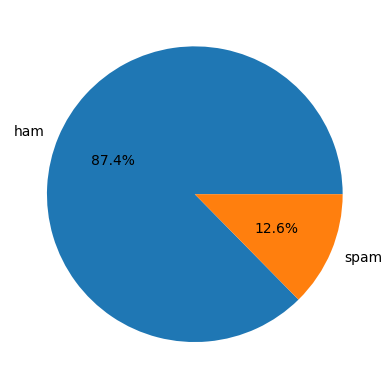

In [ ]:
plt.pie(df["category"].value_counts(), labels=['ham','spam'], autopct='%1.1f%%')
plt.show()

The data is showing that there is more number of instances for ham as opposed to spam, so there is a imbalance in the dataset, which needs to be dealt with.

In order for us to proceed with more data manipulation and further classification, we decided to label the spam and and ham with a numerical data.
```(i.e. spam = 1, ham = 0)```

In [ ]:
df['category'].replace(['ham','spam'],[0,1], inplace=True)
df.head()

,category,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Since we know that ```Message``` field contains texts, we will download ```punkt``` package from nltk to break down the texts into different parameters (e.g. ```num_char```, ```num_words```, ```num_sent```)



In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['num_char'] = df['message'].apply(len)
df.head()

,category,message,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [ ]:
df['num_words'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,category,message,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [ ]:
df['num_sent'] = df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,category,message,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


Now we can display the summary of the three fields we just created based on the category type.

In [ ]:
print("Summary of each field when category is ham:")
df[df['category']==0][['num_char', 'num_words', 'num_sent']].describe()

Summary of each field when category is ham:


,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.905890,17.267715,1.827724
std,56.715046,13.588065,1.394338
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
print("Summary of each field when category is spam:")
df[df['category']==1][['num_char', 'num_words', 'num_sent']].describe()

Summary of each field when category is spam:


,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.704441,27.762634,2.986217
std,29.821348,6.993008,1.494815
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


Histogram of Number of Characters by Category:


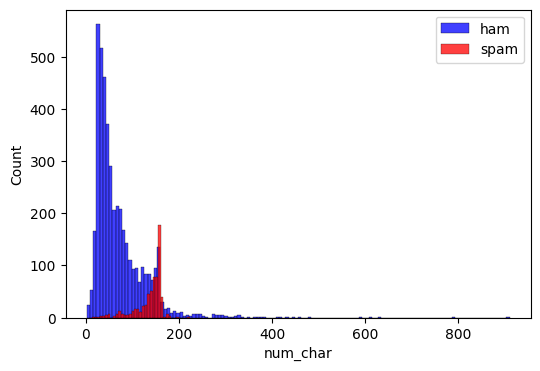

In [ ]:
print("Histogram of Number of Characters by Category:")
fig = plt.figure(figsize=(6,4))
sns.histplot(df[df['category']==0]['num_char'], color='blue')
sns.histplot(df[df['category']==1]['num_char'], color='red')
plt.legend(labels=['ham', 'spam'])
plt.show()

Histogram of Number of Words by Category:


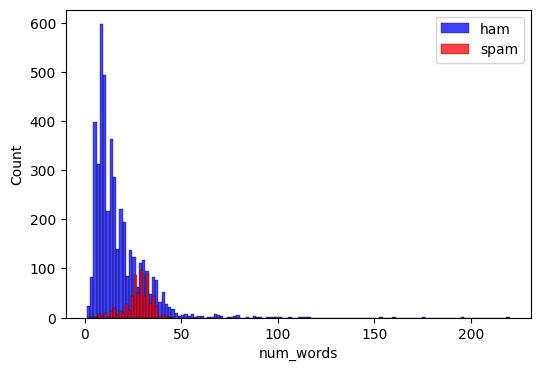

In [ ]:
print("Histogram of Number of Words by Category:")
fig = plt.figure(figsize=(6,4))
sns.histplot(df[df['category']==0]['num_words'], color='blue')
sns.histplot(df[df['category']==1]['num_words'], color='red')
plt.legend(labels=['ham', 'spam'])
plt.show()

Histogram of Number of Sentences by Category:


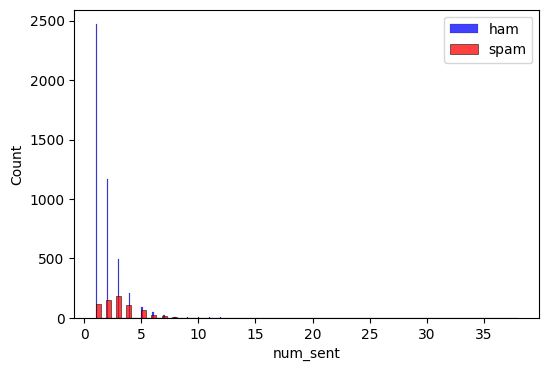

In [ ]:
print("Histogram of Number of Sentences by Category:")
fig = plt.figure(figsize=(6,4))
sns.histplot(df[df['category']==0]['num_sent'], color='blue')
sns.histplot(df[df['category']==1]['num_sent'], color='red')
plt.legend(labels=['ham', 'spam'])
plt.show()

We are now showing the correlation scores between the parameters using the heatmap to understand the pairwise correlation between different variables in the dataset.

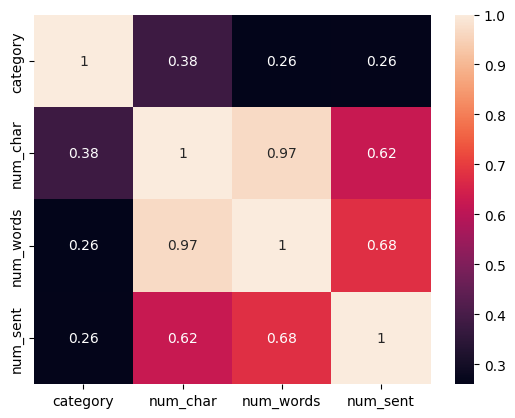

In [ ]:
sns.heatmap(df.corr(), annot=True)
plt.show()

## **Step 4: Data Pre-processing**

Now that we have reviewed the data at a high level, we can work on transforming and cleaning the data to ensure its quality, consistency, and compatibility with the selected analysis or modeling techniques.

In [ ]:
# Work on getting rid of stop words, special characters, punctuations, any links, making all the texts lower case, etc.
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,category,message,num_char,num_words,num_sent,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i dont think he goes to usf he lives aroun...


Once we have a ```message_clean``` field created, we implemented the word cloud method in EDA to understand which words appear the most frequently in both spam and ham categories.

In [ ]:
wc = WordCloud(
    background_color = None,
    width = 800,
    height = 400
)

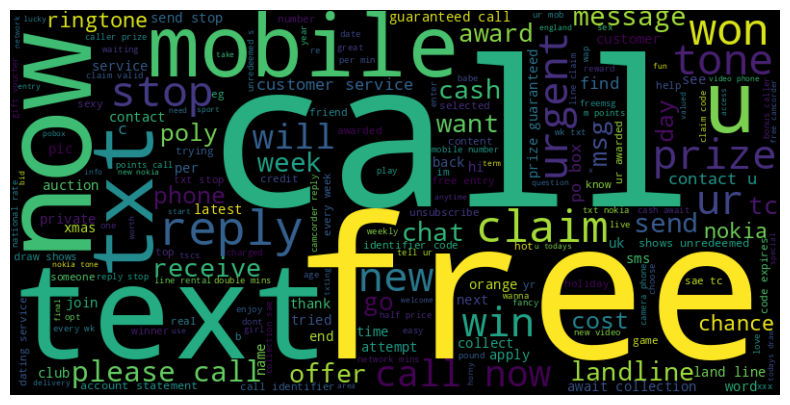

In [ ]:
spam_wc = wc.generate(df[df['category']==1]['message_clean'].str.cat(sep=' '))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

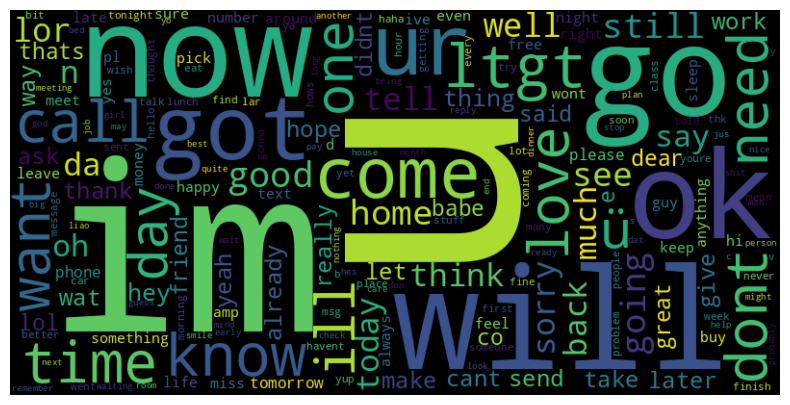

In [ ]:
ham_wc = wc.generate(df[df['category']==0]['message_clean'].str.cat(sep=' '))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Make sure we have enough Spam in the test data?
Limited data is a big challenge.

### Handling the data imbalance using ```resample()``` from sklearn package

In [ ]:
# splitting the majority vs. minority class to separate dataframes
df_0 = df[df['category']==0] # ham/majority
df_1 = df[df['category']==1] # spam/minority
print(df_0.shape)
print(df_1.shape)

(4516, 6)
(653, 6)


In [ ]:
# upsample the minority class
df_1_upsampled = resample(df_1, random_state=42, n_samples=4000, replace=True)
# concatenate the upsampled dataframe
df_upsampled = pd.concat([df_1_upsampled, df_0], ignore_index=True)
# shuffle indexes
df_upsampled = df_upsampled.sample(frac=1)
df_upsampled

,category,message,num_char,num_words,num_sent,message_clean
2048,1,December only! Had your mobile 11mths+? You ar...,158,30,4,december only had your mobile you are entitle...
338,1,"Free Msg: get Gnarls Barkleys ""Crazy"" ringtone...",100,21,1,free msg get gnarls barkleys crazy ringtone to...
5130,0,Yo dude guess who just got arrested the other day,49,10,1,yo dude guess who just got arrested the other day
6711,0,"I'm not smoking while people use ""wylie smokes...",83,18,1,im not smoking while people use wylie smokes t...
7156,0,Pls go there today &lt;#&gt; . I dont want an...,55,17,2,pls go there today ltgt i dont want any excuses
...,...,...,...,...,...,...
692,1,Join the UK's horniest Dogging service and u c...,153,32,4,join the uks horniest dogging service and u ca...
5601,0,Dont give a monkeys wot they think and i certa...,135,33,3,dont give a monkeys wot they think and i certa...
4874,0,Jay's getting really impatient and belligerent,46,7,1,jays getting really impatient and belligerent
8238,0,If I die I want u to have all my stuffs.,40,12,1,if i die i want u to have all my stuffs


After the resampling the dataset, we check the composition of the data to see how the distribution of each label has changed.

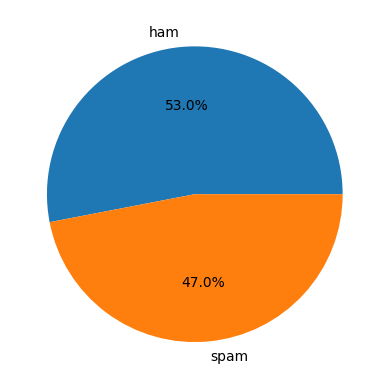

In [ ]:
plt.pie(df_upsampled["category"].value_counts(), labels=['ham','spam'], autopct='%1.1f%%')
plt.show()

We then split the dataset into three categories: train, val, and test using sklearn.model_selection package.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled['message'], df_upsampled['category'], test_size=0.1, random_state=42)

In [ ]:
X_train.head()

5291                      Yeah we do totes. When u wanna?
7805    I forgot 2 ask ü all smth.. There's a card on ...
6647    Babe, have you got enough money to pick up bre...
3827    1000's flirting NOW! Txt GIRL or BLOKE & ur NA...
1168    Welcome to Select, an O2 service with added be...
Name: message, dtype: object

In [ ]:
X_train.count()

7664

In [ ]:
X_test.count()

852

## **Step 5: Baseline Model**

We build our baseline model by implementing a Logistic Regression.

First, use SpaCy English language model to turn words into vectors.

In [ ]:
# Load the SpaCy en_core_web_sm model
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])

# create train set by getting the document vector
docs_train = [nlp(doc).vector for doc in X_train]
X_train_vec = np.vstack(docs_train)
print('Shape of train set: {}'.format(X_train_vec.shape))

# create test set likewise
docs_test = [nlp(doc).vector for doc in X_test]
X_test_vec = np.vstack(docs_test)
print('Shape of test set: {}'.format(X_test_vec.shape))


Shape of train set: (7664, 96)
Shape of test set: (852, 96)


In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_vec, y_train)

LogisticRegression()

In [ ]:
y_pred = logistic_regression.predict(X_test_vec)

In [ ]:
print("accuracy:", accuracy_score(y_test, y_pred))
print("loss", zero_one_loss(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("f1 score:", f1_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))

accuracy: 0.9424882629107981
loss 0.057511737089201875
precision: 0.9444444444444444
f1 score: 0.9385194479297365
recall: 0.9326683291770573


## **Step 6: LSTM Model**
We try implementing a RNN model to detect spam SMS. Below is the Rnn model with LSTM layer


Below is the RNN model with LSTM layer

In [ ]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

In [ ]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

In [ ]:
rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)

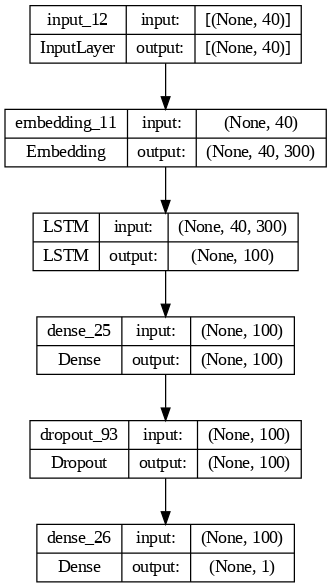

In [ ]:
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [ ]:
rnn_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 40)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 40, 300)           13194600  
                                                                 
 LSTM (LSTM)                 (None, 100)               160400    
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dropout_93 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 101       
                                                                 
Total params: 13365201 (50.98 MB)
Trainable params: 170601

In [ ]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
240/240 [==============================] - 27s 95ms/step - loss: 0.2728 - accuracy: 0.8974 - val_loss: 0.1875 - val_accuracy: 0.9284
Epoch 2/5
240/240 [==============================] - 18s 77ms/step - loss: 0.1904 - accuracy: 0.9382 - val_loss: 0.1831 - val_accuracy: 0.9390
Epoch 3/5
240/240 [==============================] - 17s 70ms/step - loss: 0.1414 - accuracy: 0.9521 - val_loss: 0.1072 - val_accuracy: 0.9660
Epoch 4/5
240/240 [==============================] - 18s 73ms/step - loss: 0.1097 - accuracy: 0.9626 - val_loss: 0.1110 - val_accuracy: 0.9624
Epoch 5/5
240/240 [==============================] - 18s 73ms/step - loss: 0.0936 - accuracy: 0.9686 - val_loss: 0.1137 - val_accuracy: 0.9542


In [ ]:
yhat_probs = rnn_model.predict(test_input)
yhat_probs = yhat_probs[:, 0]
yhat_classes = (yhat_probs > 0.5).astype("int32")
yhat_classes

27/27 [==============================] - 1s 29ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,

In [ ]:
print("accuracy:", accuracy_score(test_labels, yhat_classes))
print("precision:", precision_score(test_labels, yhat_classes))
print("f1 score:", f1_score(test_labels, yhat_classes))
print("recall:", recall_score(test_labels, yhat_classes))

accuracy: 0.954225352112676
precision: 0.9191011235955057
f1 score: 0.9544924154025671
recall: 0.9927184466019418


## **Step 7: CNN Model**
We try implementing a CNN model to detect spam SMS.

We first tokenize the texts using Word2Vec.

In [ ]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


Build the embedding matrix and a vocabulary dictionary

In [ ]:
EMBEDDING_DIM = len(word2vec_model['university'])

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(word2vec_model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(word2vec_model.index_to_key):
    embedding_vector = word2vec_model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape

(43982, 300)

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(X_train)
test_tokens = tokenizer.tokenize(X_test)

In [ ]:
print("The longest train token has the length = ", max([len(x) for x in train_tokens]))
print("The longest test token has the length = ", max([len(x) for x in test_tokens]))

The longest train token has the length =  171
The longest test token has the length =  96


MAX character parameters need to take into consideration how short the SMS texts are. It was initially set for 150 but we changed the parameter to be 40 and the model performance improved significantly.

In [ ]:
# MAX_SEQUENCE_LENGTH = 150
MAX_SEQUENCE_LENGTH = 40

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [ ]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(y_train)
test_labels = np.array(y_test)

Examples processed:  0
Examples processed:  5000
Total examples:  7663
Examples processed:  0
Total examples:  851


In [ ]:
train_input.shape

(7664, 40)

In [ ]:
test_input.shape

(852, 40)

Here's a function that defines the CNN model

In [ ]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [ ]:
cnn_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 40)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 40, 300)              1319460   ['input_11[0][0]']            
                                                          0                                       
                                                                                                  
 conv1d_8 (Conv1D)           (None, 38, 100)              90100     ['embedding_10[0][0]']        
                                                                                                  
 conv1d_9 (Conv1D)           (None, 37, 100)              120100    ['embedding_10[0][0]'] 

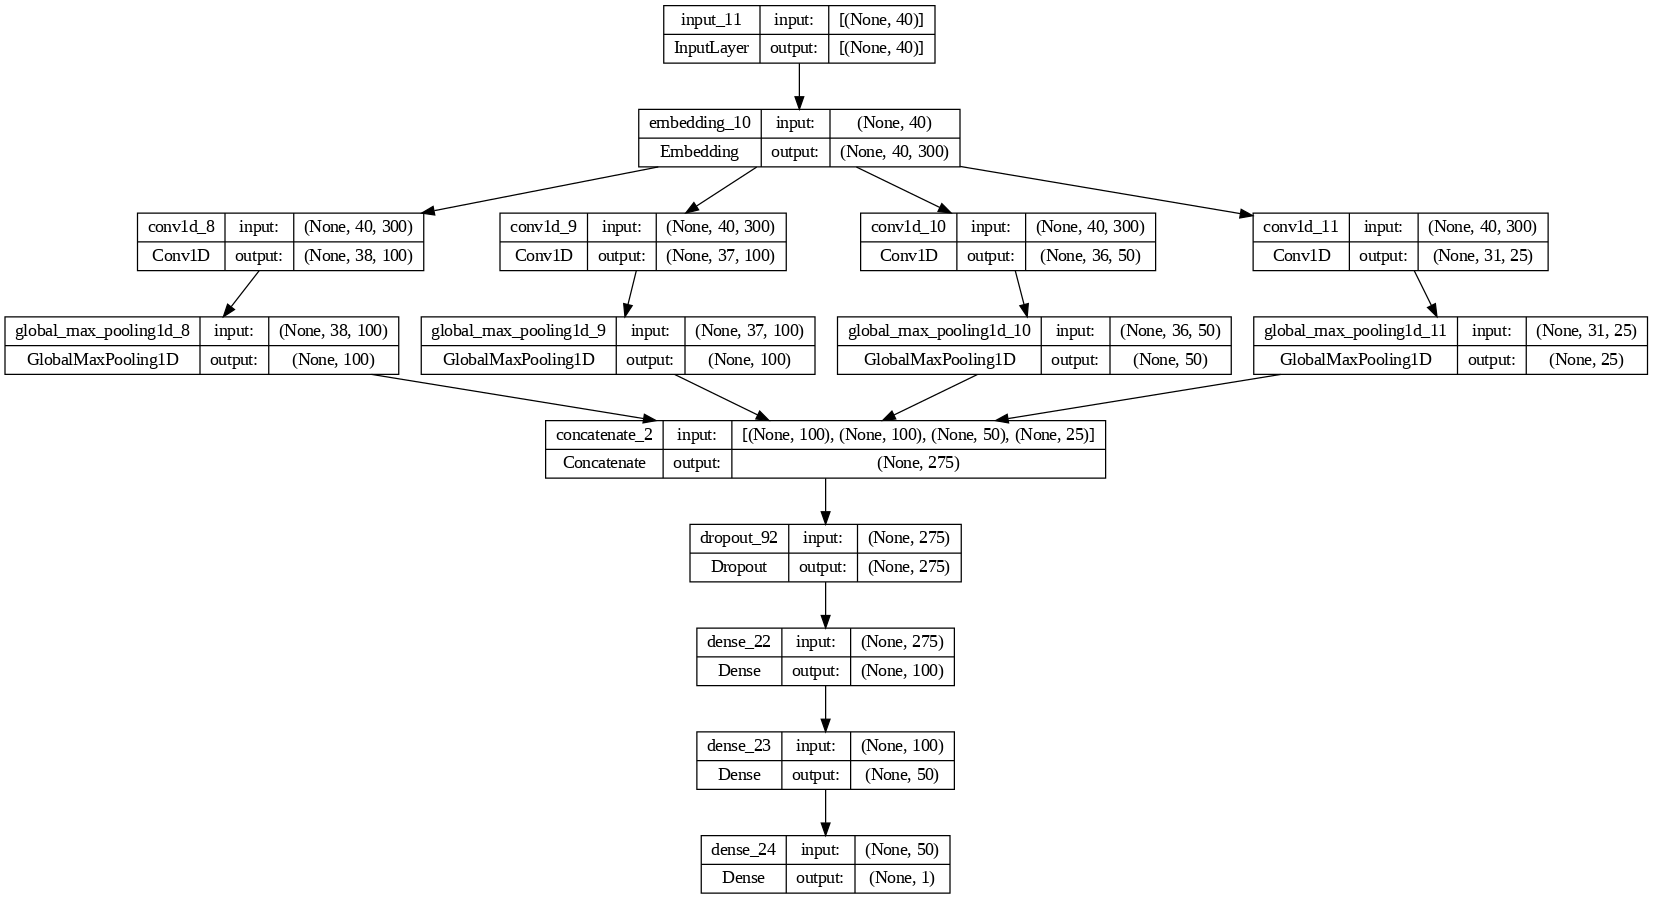

In [ ]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [ ]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
240/240 [==============================] - 20s 76ms/step - loss: 0.1698 - accuracy: 0.9396 - val_loss: 0.0339 - val_accuracy: 0.9883
Epoch 2/5
240/240 [==============================] - 21s 86ms/step - loss: 0.0476 - accuracy: 0.9834 - val_loss: 0.0184 - val_accuracy: 0.9941
Epoch 3/5
240/240 [==============================] - 18s 74ms/step - loss: 0.0220 - accuracy: 0.9914 - val_loss: 0.0143 - val_accuracy: 0.9941
Epoch 4/5
240/240 [==============================] - 18s 76ms/step - loss: 0.0237 - accuracy: 0.9907 - val_loss: 0.0246 - val_accuracy: 0.9894
Epoch 5/5
240/240 [==============================] - 16s 65ms/step - loss: 0.0263 - accuracy: 0.9897 - val_loss: 0.0194 - val_accuracy: 0.9918


In [ ]:
yhat_probs = cnn_model.predict(test_input)
yhat_probs = yhat_probs[:, 0]
yhat_classes = (yhat_probs > 0.5).astype("int32")
yhat_classes

27/27 [==============================] - 1s 20ms/step


array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,

In [ ]:
print("accuracy:", accuracy_score(test_labels, yhat_classes))
print("precision:", precision_score(test_labels, yhat_classes))
print("f1 score:", f1_score(test_labels, yhat_classes))
print("recall:", recall_score(test_labels, yhat_classes))

accuracy: 0.9917840375586855
precision: 0.9951100244498777
f1 score: 0.9914738124238733
recall: 0.9878640776699029


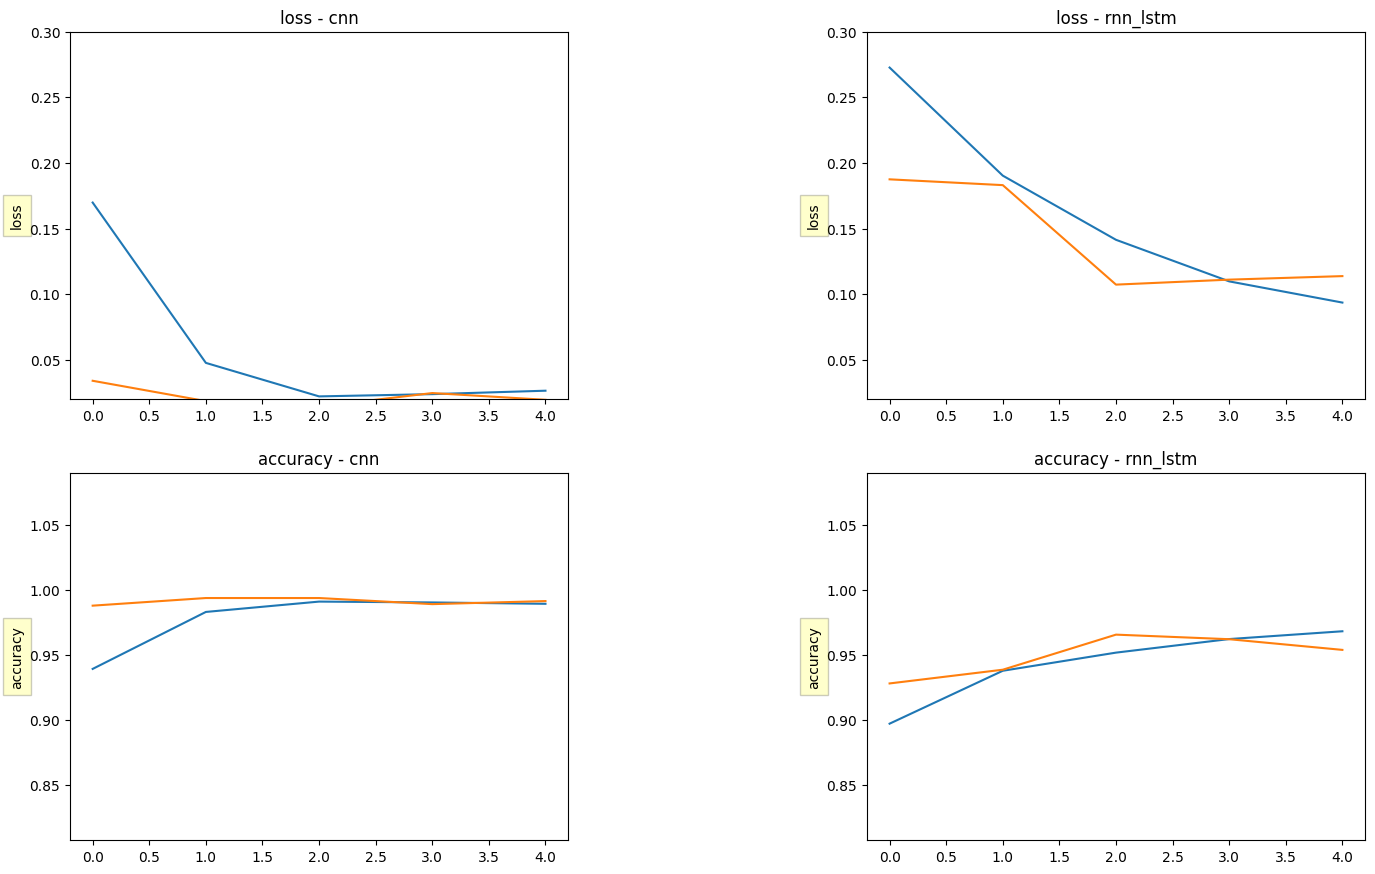

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          rnn_history,
          model_1_name='cnn',
          model_2_name='rnn_lstm')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

## **Step 8: BERT**

We now implement BERT model to detect spam SMS.
We should try BERT case and uncase model, and BERTweet

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
type(X_train)

pandas.core.series.Series

In [ ]:
#@title BERT Tokenization of training and test data
bert_train_tokenized = bert_tokenizer(X_train.tolist(),
                                      max_length=MAX_SEQUENCE_LENGTH,
                                      truncation=True,
                                      padding='max_length',
                                      return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(y_train)

bert_test_tokenized = bert_tokenizer(X_test.tolist(),
                                     max_length=MAX_SEQUENCE_LENGTH,
                                     truncation=True,
                                     padding='max_length',
                                     return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                    bert_test_tokenized.token_type_ids,
                    bert_test_tokenized.attention_mask]
bert_test_labels = np.array(y_test)

In [ ]:
len(bert_train_inputs)

3

In [ ]:
len(bert_train_inputs[0])

7664

In [ ]:
len(bert_test_inputs[0])

852

In [ ]:
#@title BERT Input ID
bert_train_inputs[0][0]

<tf.Tensor: shape=(40,), dtype=int32, numpy=
array([  101, 18455,  1115,  1116,  2503,   119,   146,  1547,  1138,
         170, 22956, 24438,  1186,   106,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)>

In [ ]:
#@title BERT Token Type ID
bert_train_inputs[1][0]

<tf.Tensor: shape=(40,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
#@title BERT Attention Mask
bert_train_inputs[2][0]

<tf.Tensor: shape=(40,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
def bert_encode(data, MAX_SEQUENCE_LENGTH) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode(
            text,
            add_special_tokens=True,
            max_length=MAX_SEQUENCE_LENGTH,
            padding='max_length',

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [ ]:
# Defining functions for different performance metrics
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
    precision_score_ = precision(y_true, y_pred)
    recall_score_ = recall(y_true, y_pred)
    return 2*((precision_score_*recall_score_)/(precision_score_+recall_score_+K.epsilon()))

### BERT approach 1: BERT with a pooler token

In [ ]:
def bert_classification_model_pooler(bert_model,
                                     num_train_layers=0,
                                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                                     hidden_size = 100,
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1, precision, recall])

    return classification_model

In [ ]:
bert_classification_model = bert_classification_model_pooler(bert_model, num_train_layers=0)

In [ ]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                      

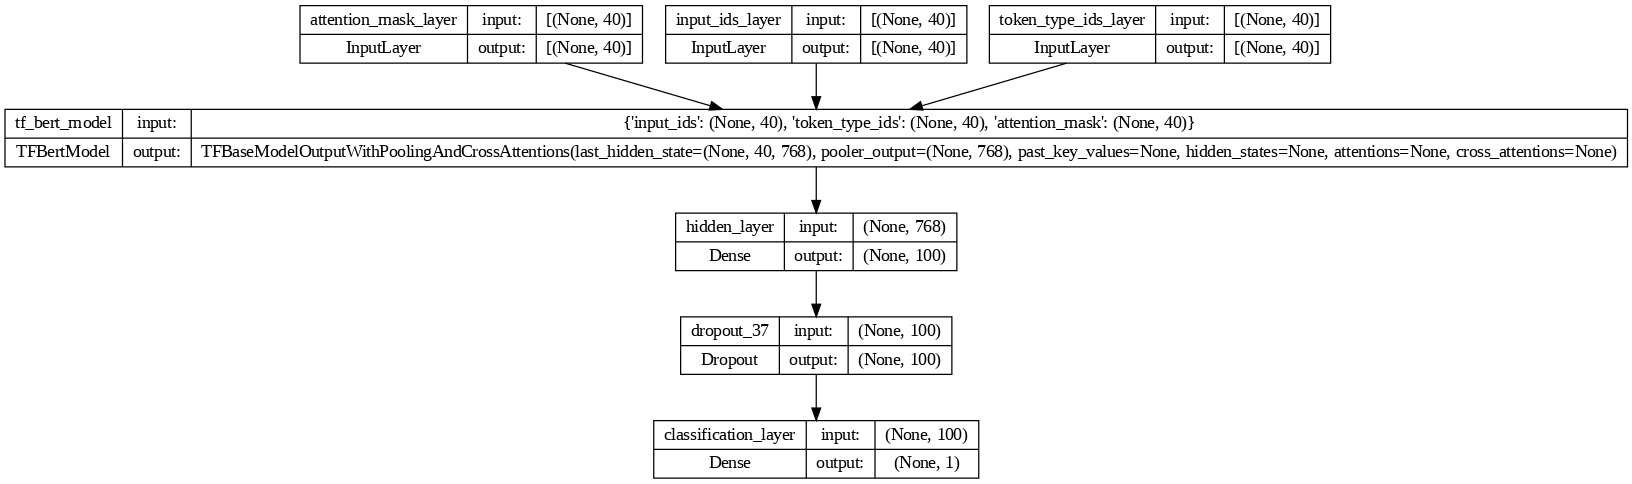

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [ ]:
bert_classification_model_history = bert_classification_model.fit(
                                      bert_train_inputs,
                                      bert_train_labels,
                                      validation_data=(bert_test_inputs, bert_test_labels),
                                      batch_size=32,
                                      epochs=5
                                      )

Epoch 1/5
240/240 [==============================] - 844s 3s/step - loss: 0.6289 - accuracy: 0.6511 - f1: 0.5952 - precision: 0.6564 - recall: 0.5764 - val_loss: 0.5449 - val_accuracy: 0.8239 - val_f1: 0.8200 - val_precision: 0.7537 - val_recall: 0.9126
Epoch 2/5
240/240 [==============================] - 831s 3s/step - loss: 0.5131 - accuracy: 0.8062 - f1: 0.7822 - precision: 0.8094 - recall: 0.7770 - val_loss: 0.4539 - val_accuracy: 0.8815 - val_f1: 0.8664 - val_precision: 0.8627 - val_recall: 0.8831
Epoch 3/5
240/240 [==============================] - 832s 3s/step - loss: 0.4295 - accuracy: 0.8665 - f1: 0.8540 - precision: 0.8606 - recall: 0.8582 - val_loss: 0.3837 - val_accuracy: 0.8932 - val_f1: 0.8789 - val_precision: 0.8782 - val_recall: 0.8908
Epoch 4/5
240/240 [==============================] - 832s 3s/step - loss: 0.3766 - accuracy: 0.8810 - f1: 0.8708 - precision: 0.8676 - recall: 0.8838 - val_loss: 0.3392 - val_accuracy: 0.9085 - val_f1: 0.8948 - val_precision: 0.9168 - val

### BERT approach 2: BERT with a CLS token

In [ ]:
def bert_classification_model_cls(bert_model,
                                     num_train_layers=0,
                                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                                     hidden_size = 100,
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS token for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1, precision, recall])

    return classification_model

In [ ]:
bert_classification_model = bert_classification_model_cls(bert_model, num_train_layers=0)

In [ ]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                    

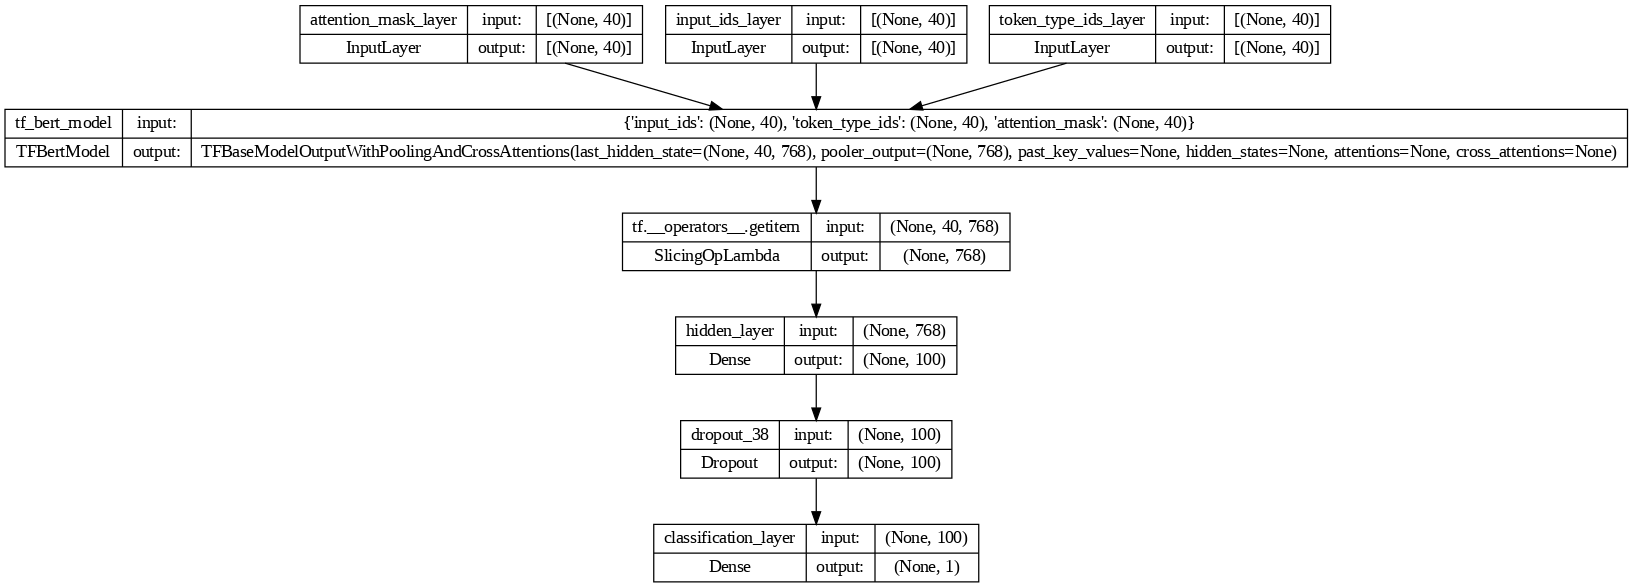

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [ ]:
bert_classification_model_history = bert_classification_model.fit(
                                      bert_train_inputs,
                                      bert_train_labels,
                                      validation_data=(bert_test_inputs, bert_test_labels),
                                      batch_size=32,
                                      epochs=5
                                      )

Epoch 1/5
240/240 [==============================] - 848s 3s/step - loss: 0.4818 - accuracy: 0.7978 - f1: 0.7755 - precision: 0.7983 - recall: 0.7686 - val_loss: 0.2730 - val_accuracy: 0.9437 - val_f1: 0.9374 - val_precision: 0.9212 - val_recall: 0.9588
Epoch 2/5
240/240 [==============================] - 831s 3s/step - loss: 0.2476 - accuracy: 0.9353 - f1: 0.9302 - precision: 0.9281 - recall: 0.9373 - val_loss: 0.1700 - val_accuracy: 0.9542 - val_f1: 0.9491 - val_precision: 0.9437 - val_recall: 0.9588
Epoch 3/5
240/240 [==============================] - 831s 3s/step - loss: 0.1844 - accuracy: 0.9456 - f1: 0.9403 - precision: 0.9402 - recall: 0.9443 - val_loss: 0.1364 - val_accuracy: 0.9554 - val_f1: 0.9500 - val_precision: 0.9431 - val_recall: 0.9613
Epoch 4/5
240/240 [==============================] - 832s 3s/step - loss: 0.1525 - accuracy: 0.9566 - f1: 0.9524 - precision: 0.9549 - recall: 0.9532 - val_loss: 0.1194 - val_accuracy: 0.9577 - val_f1: 0.9526 - val_precision: 0.9433 - val

### BERT approach 3: BERT-CNN Ensemble

In [ ]:
def bert_classification_model_cnn(bert_model,
                                  num_train_layers=0,
                                  max_sequence_length=MAX_SEQUENCE_LENGTH,
                                  num_filters = [100, 100, 50, 25],
                                  kernel_sizes = [3, 4, 5, 10],
                                  hidden_size = 100,
                                  dropout=0.3,
                                  learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]
    cnn_token = bert_out[0]

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_token)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # classification layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_output)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1, precision, recall])

    return classification_model

In [ ]:
bert_classification_model = bert_classification_model_cnn(bert_model)

In [ ]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                      

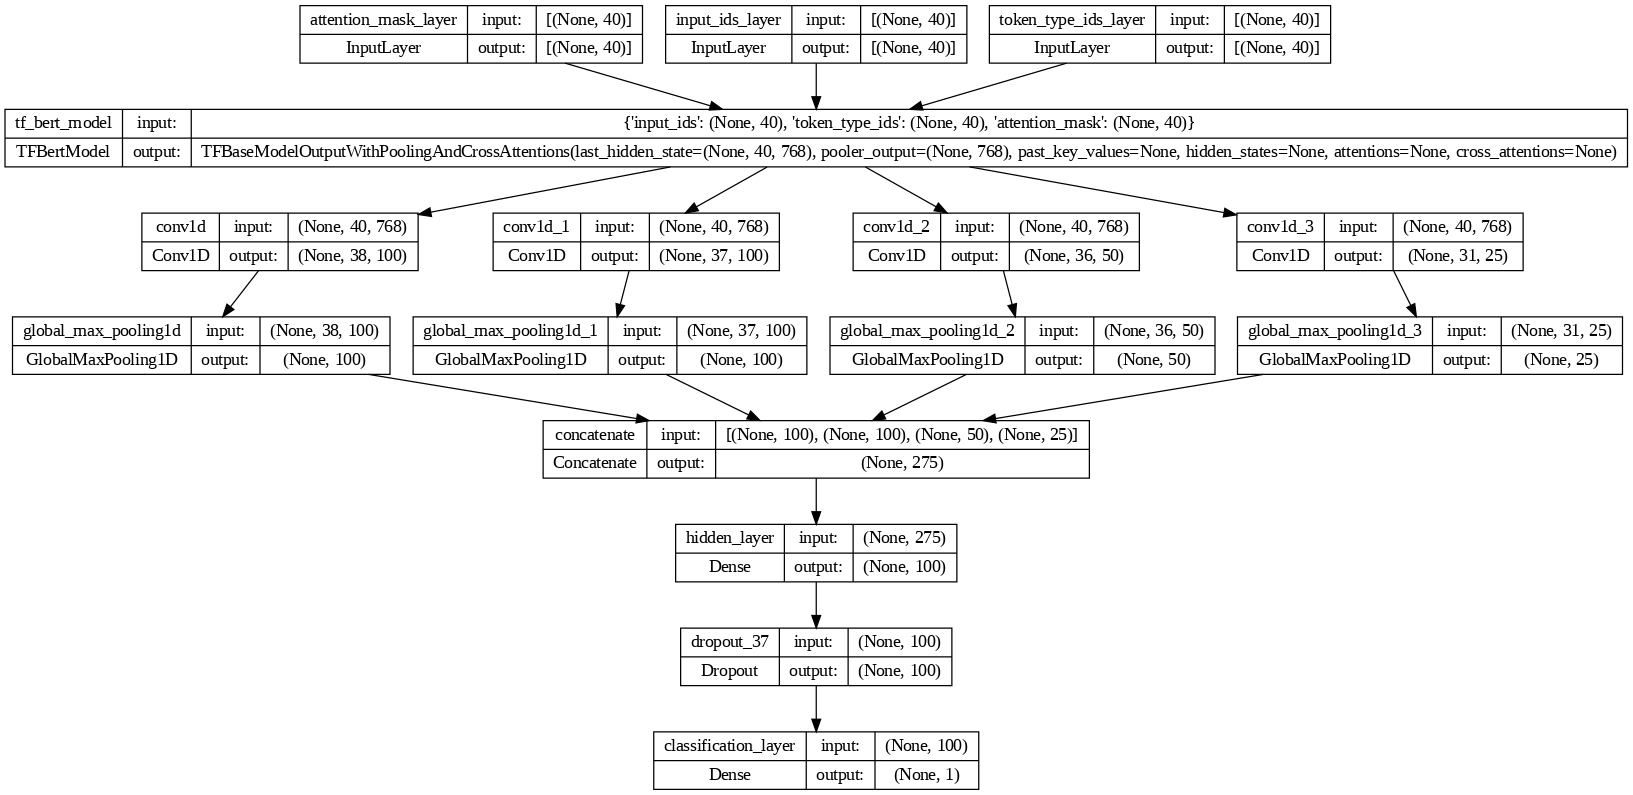

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [ ]:
bert_classification_model_history = bert_classification_model.fit(
                                      bert_train_inputs,
                                      bert_train_labels,
                                      validation_data=(bert_test_inputs, bert_test_labels),
                                      batch_size=32,
                                      epochs=5
                                      )

Epoch 1/5
240/240 [==============================] - 1605s 7s/step - loss: 0.1752 - accuracy: 0.9310 - f1: 0.9220 - precision: 0.9261 - recall: 0.9224 - val_loss: 0.0518 - val_accuracy: 0.9789 - val_f1: 0.9781 - val_precision: 0.9773 - val_recall: 0.9804
Epoch 2/5
240/240 [==============================] - 1522s 6s/step - loss: 0.0635 - accuracy: 0.9774 - f1: 0.9755 - precision: 0.9785 - recall: 0.9742 - val_loss: 0.0303 - val_accuracy: 0.9918 - val_f1: 0.9913 - val_precision: 0.9861 - val_recall: 0.9972
Epoch 3/5
240/240 [==============================] - 1523s 6s/step - loss: 0.0364 - accuracy: 0.9901 - f1: 0.9893 - precision: 0.9894 - recall: 0.9900 - val_loss: 0.0164 - val_accuracy: 0.9953 - val_f1: 0.9949 - val_precision: 0.9930 - val_recall: 0.9972
Epoch 4/5
240/240 [==============================] - 1524s 6s/step - loss: 0.0239 - accuracy: 0.9943 - f1: 0.9939 - precision: 0.9936 - recall: 0.9945 - val_loss: 0.0116 - val_accuracy: 0.9965 - val_f1: 0.9961 - val_precision: 0.9953 -

## **Step 9: BERTweet**
We implemented BERTweet as an enhanced version of our existing BERT model.

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                               normalization=True,
                                               use_fast = False,
                                               add_special_tokens=True,
                                               pad_to_max_length=True,
                                               return_attention_mask=True)

bert_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

In [ ]:
X_train[0]

'+449071512431 URGENT! This is the 2nd attempt to contact U!U have WON £1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. max£7. 50'

In [ ]:
#@title BERTweet Tokenization of training and test data
bert_train_tokenized = bert_tokenizer(X_train.tolist(),
                                      max_length=MAX_SEQUENCE_LENGTH,
                                      truncation=True,
                                      padding='max_length',
                                      return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(y_train)

bert_test_tokenized = bert_tokenizer(X_test.tolist(),
                                     max_length=MAX_SEQUENCE_LENGTH,
                                     truncation=True,
                                     padding='max_length',
                                     return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                    bert_test_tokenized.token_type_ids,
                    bert_test_tokenized.attention_mask]
bert_test_labels = np.array(y_test)

In [ ]:
len(bert_train_inputs)

3

In [ ]:
#@title BERTweet Input ID
bert_train_inputs[0][0]

<tf.Tensor: shape=(40,), dtype=int32, numpy=
array([    0,  1232,   850,   633, 20443,   737, 41137,     2,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1], dtype=int32)>

In [ ]:
#@title BERTweet Token Type ID
bert_train_inputs[1][0]

<tf.Tensor: shape=(40,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
#@title BERTweet Attention Mask
bert_train_inputs[2][0]

<tf.Tensor: shape=(40,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

### BERTweet approach 1: BERTweet with a pooler token

In [ ]:
def bertweet_classification_model_pooler(bert_model,
                                         num_train_layers=0,
                                         max_sequence_length=MAX_SEQUENCE_LENGTH,
                                         hidden_size = 100,
                                         dropout=0.3,
                                         learning_rate=0.00005):
    """
    Build a simple classification model with BERTweet.
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_output = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1, precision, recall])

    return classification_model

In [ ]:
bertweet_classification_model = bertweet_classification_model_pooler(bert_model, num_train_layers=0)

In [ ]:
#confirm all layers are frozen
bertweet_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                      

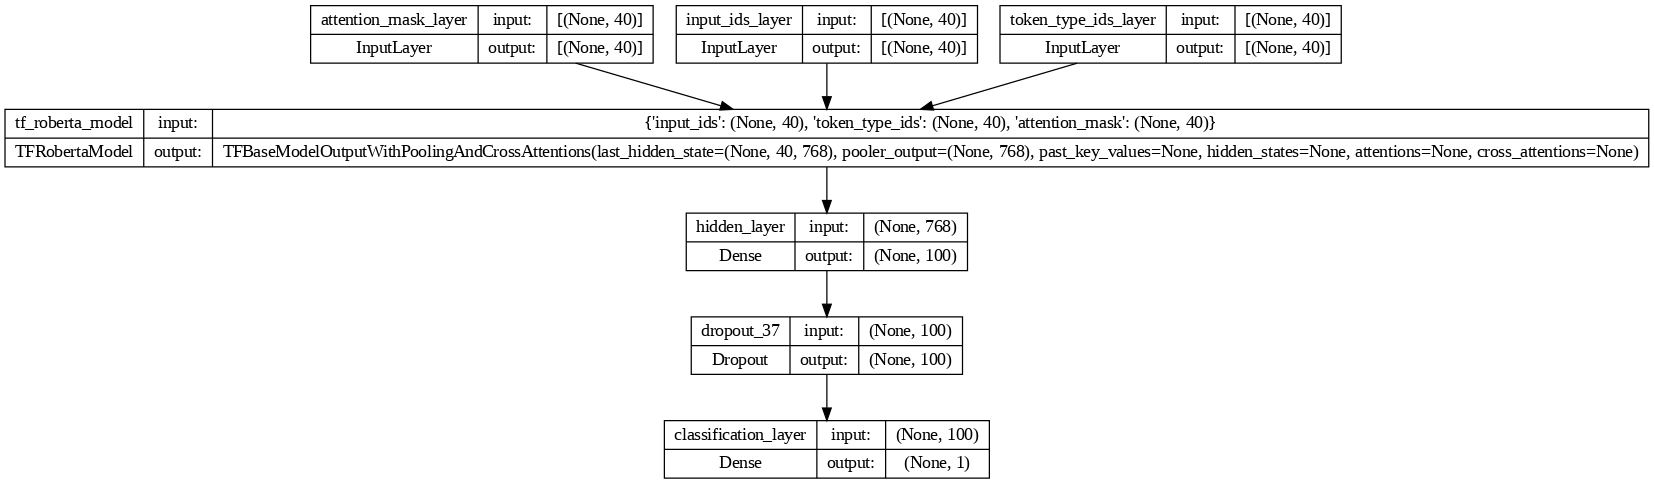

In [ ]:
keras.utils.plot_model(bertweet_classification_model, show_shapes=True, dpi=90)

In [ ]:
bertweet_classification_model_history = bertweet_classification_model.fit(
                                          bert_train_inputs,
                                          bert_train_labels,
                                          validation_data=(bert_test_inputs, bert_test_labels),
                                          batch_size=32,
                                          epochs=5
                                          )

Epoch 1/5
240/240 [==============================] - 1317s 5s/step - loss: 0.6105 - accuracy: 0.7411 - f1: 0.6775 - precision: 0.7692 - recall: 0.6275 - val_loss: 0.4924 - val_accuracy: 0.9014 - val_f1: 0.8830 - val_precision: 0.9865 - val_recall: 0.8039
Epoch 2/5
240/240 [==============================] - 1282s 5s/step - loss: 0.4484 - accuracy: 0.8997 - f1: 0.8824 - precision: 0.9443 - recall: 0.8348 - val_loss: 0.3541 - val_accuracy: 0.9401 - val_f1: 0.9287 - val_precision: 0.9791 - val_recall: 0.8868
Epoch 3/5
240/240 [==============================] - 1282s 5s/step - loss: 0.3431 - accuracy: 0.9269 - f1: 0.9153 - precision: 0.9660 - recall: 0.8747 - val_loss: 0.2694 - val_accuracy: 0.9554 - val_f1: 0.9470 - val_precision: 0.9822 - val_recall: 0.9173
Epoch 4/5
240/240 [==============================] - 1283s 5s/step - loss: 0.2772 - accuracy: 0.9349 - f1: 0.9243 - precision: 0.9681 - recall: 0.8882 - val_loss: 0.2145 - val_accuracy: 0.9589 - val_f1: 0.9516 - val_precision: 0.9849 -

### BERTweet approach 2: BERTweet with a CLS token

In [ ]:
def bertweet_classification_model_cls(bert_model,
                                         num_train_layers=0,
                                         max_sequence_length=MAX_SEQUENCE_LENGTH,
                                         hidden_size = 100,
                                         dropout=0.3,
                                         learning_rate=0.00005):
    """
    Build a simple classification model with BERTweet.
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_output = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_output)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1, precision, recall])

    return classification_model

In [ ]:
bertweet_classification_model = bertweet_classification_model_cls(bert_model, num_train_layers=0)

In [ ]:
#confirm all layers are frozen
bertweet_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                      

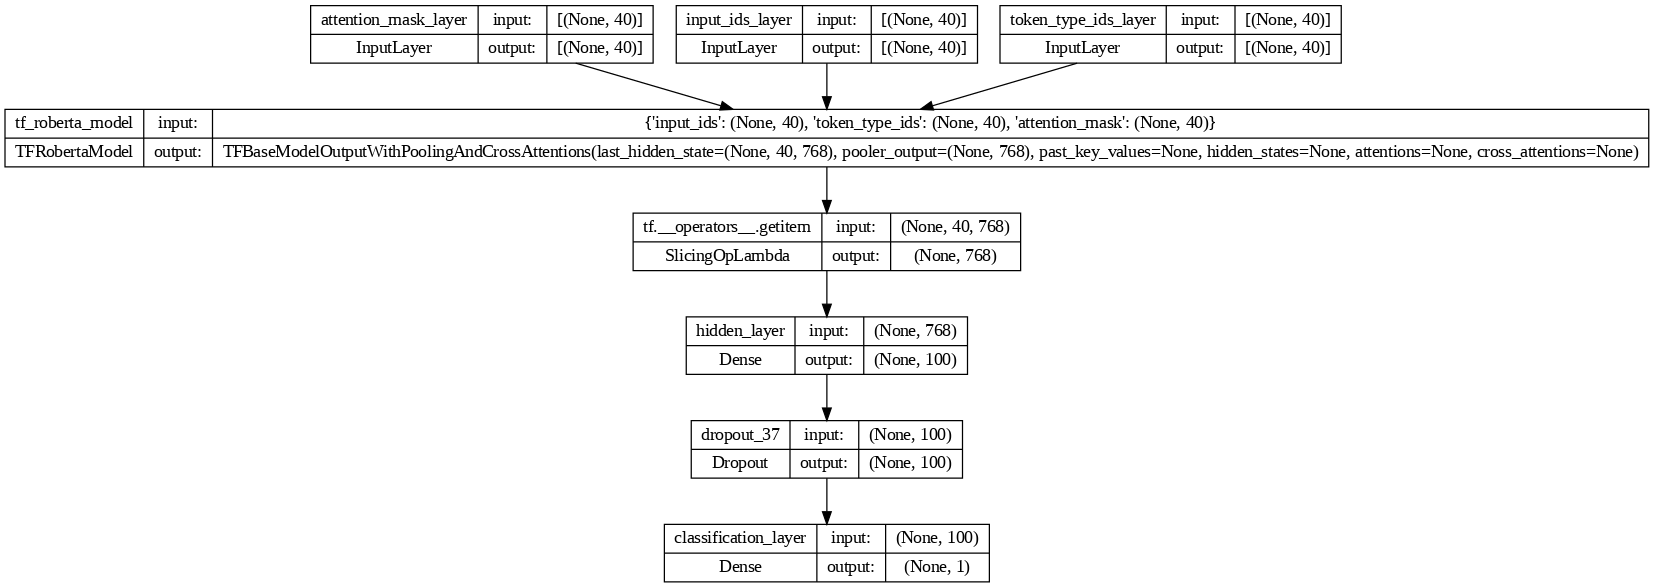

In [ ]:
keras.utils.plot_model(bertweet_classification_model, show_shapes=True, dpi=90)

In [ ]:
bertweet_classification_model_history = bertweet_classification_model.fit(
                                          bert_train_inputs,
                                          bert_train_labels,
                                          validation_data=(bert_test_inputs, bert_test_labels),
                                          batch_size=32,
                                          epochs=5
                                          )

Epoch 1/5
240/240 [==============================] - 1277s 5s/step - loss: 0.5672 - accuracy: 0.7585 - f1: 0.7108 - precision: 0.7768 - recall: 0.6708 - val_loss: 0.4165 - val_accuracy: 0.9214 - val_f1: 0.9038 - val_precision: 0.9526 - val_recall: 0.8625
Epoch 2/5
240/240 [==============================] - 1278s 5s/step - loss: 0.3486 - accuracy: 0.9184 - f1: 0.9078 - precision: 0.9423 - recall: 0.8806 - val_loss: 0.2509 - val_accuracy: 0.9401 - val_f1: 0.9280 - val_precision: 0.9702 - val_recall: 0.8922
Epoch 3/5
240/240 [==============================] - 1281s 5s/step - loss: 0.2373 - accuracy: 0.9443 - f1: 0.9362 - precision: 0.9700 - recall: 0.9087 - val_loss: 0.1894 - val_accuracy: 0.9472 - val_f1: 0.9355 - val_precision: 0.9782 - val_recall: 0.8989
Epoch 4/5
240/240 [==============================] - 1269s 5s/step - loss: 0.1920 - accuracy: 0.9482 - f1: 0.9420 - precision: 0.9726 - recall: 0.9161 - val_loss: 0.1605 - val_accuracy: 0.9484 - val_f1: 0.9368 - val_precision: 0.9783 -

### BERTweet approach 3: BERTweet-CNN Ensemble

In [ ]:
def bertweet_classification_model_cnn(bert_model,
                                      num_train_layers=0,
                                      max_sequence_length=MAX_SEQUENCE_LENGTH,
                                      num_filters = [100, 100, 50, 25],
                                      kernel_sizes = [3, 4, 5, 10],
                                      hidden_size = 100,
                                      dropout=0.3,
                                      learning_rate=0.00005):
    """
    Build a simple classification model with BERTweet.
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    #cls_output = bert_out[0][:, 0, :]
    cnn_token = bert_out[0]

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_token)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # classification layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_output)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1, precision, recall])

    return classification_model

In [ ]:
bertweet_classification_model = bertweet_classification_model_cnn(bert_model, num_train_layers=0)

In [ ]:
#confirm all layers are frozen
bertweet_classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 40)]                 0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 40)]                 0         []                            
 tLayer)                                                                                    

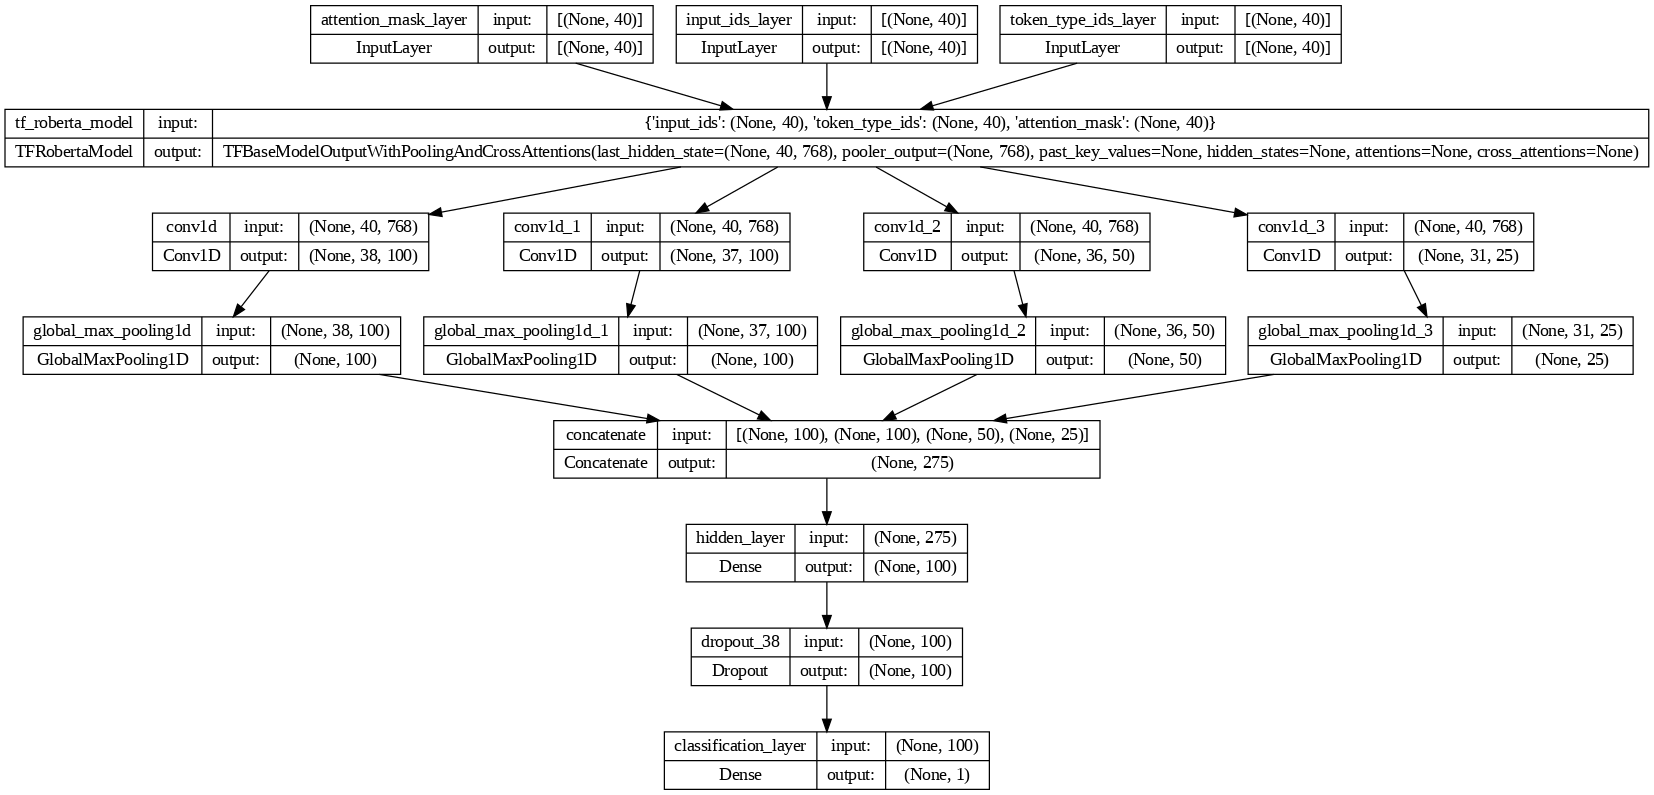

In [ ]:
keras.utils.plot_model(bertweet_classification_model, show_shapes=True, dpi=90)

In [ ]:
bertweet_classification_model_history = bertweet_classification_model.fit(
                                          bert_train_inputs,
                                          bert_train_labels,
                                          validation_data=(bert_test_inputs, bert_test_labels),
                                          batch_size=32,
                                          epochs=5
                                          )

Epoch 1/5
240/240 [==============================] - 1305s 5s/step - loss: 0.1821 - accuracy: 0.9362 - f1: 0.9307 - precision: 0.9431 - recall: 0.9233 - val_loss: 0.0684 - val_accuracy: 0.9789 - val_f1: 0.9775 - val_precision: 0.9925 - val_recall: 0.9642
Epoch 2/5
240/240 [==============================] - 1279s 5s/step - loss: 0.0520 - accuracy: 0.9850 - f1: 0.9828 - precision: 0.9921 - recall: 0.9751 - val_loss: 0.0366 - val_accuracy: 0.9941 - val_f1: 0.9938 - val_precision: 0.9927 - val_recall: 0.9954
Epoch 3/5
240/240 [==============================] - 1278s 5s/step - loss: 0.0296 - accuracy: 0.9924 - f1: 0.9917 - precision: 0.9942 - recall: 0.9897 - val_loss: 0.0184 - val_accuracy: 0.9977 - val_f1: 0.9978 - val_precision: 0.9958 - val_recall: 1.0000
Epoch 4/5
240/240 [==============================] - 1278s 5s/step - loss: 0.0158 - accuracy: 0.9971 - f1: 0.9968 - precision: 0.9975 - recall: 0.9964 - val_loss: 0.0122 - val_accuracy: 0.9977 - val_f1: 0.9978 - val_precision: 0.9958 -

## **Step 10: Performance**

We compile the performance of all NLP models for a side-by-side comparison.



Models | Baseline | RNN-LSTM | CNN  | BERT-Pooler | BERT-CLS | BERT-CNN | BERTweet-Pooler | BERTweet-CLS | BERTweet-CNN |
--------------|-------------|--------------|-------------|--------------|-------------|--------------|-------------|--------------|-------------|
Loss | 0.0575 | 0.1137 | 0.0194 | 0.3035 | 0.1053 | 0.0078 | 0.1794 | 0.1400 | 0.0071 |
Accuracy  | 0.9425 | 0.9542 | 0.9918 | 0.9061 | 0.9660 | 0.9988 | 0.9624 | 0.9589 | 0.9988 |
Precision | 0.9444 | 0.9191 | 0.9951 | 0.8980 | 0.9620 | 0.9974 | 0.9852 | 0.9763 | 0.9978 |
Recall | 0.9327 | 0.9927 | 0.9879 | 0.8967 | 0.9633 | 1.0000 | 0.9318 | 0.9238 | 1.0000 |
F1 | 0.9385 | 0.9545 | 0.9915 | 0.8936 | 0.9610 | 0.9986 | 0.9566 | 0.9478 | 0.9989 |


Below is a confusion matrix that represents the outcome of BERTweet-CNN ensemble model.

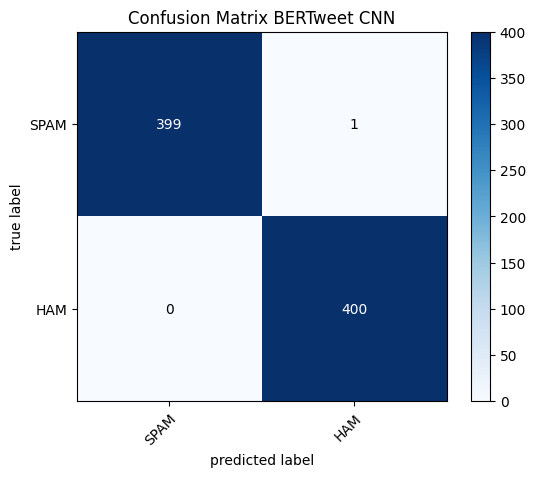

In [1]:
# Imports
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# Your Confusion Matrix
cm = np.array([[399, 1],
               [0.00, 400.00]])

# Classes
classes = ['class A', 'class B']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = False,
                                   #show_decimal = True,
                                   colorbar = True)

ax.set_title('Confusion Matrix BERTweet CNN');
ax.xaxis.set_ticklabels(['SPAM', 'HAM']); ax.yaxis.set_ticklabels(['SPAM', 'HAM']);

plt.show(FormatStrFormatter('%.5f'))